[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CoolandHot/DATA5709Capstone/blob/main/DATA5709_Capstone_InitialDataAnalysis.ipynb)

In [ ]:
image_save_path_prefix = '/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/'

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

## <font color='yellow'>Load</font> preprocessed datasets


In [ ]:
# under "/content/drive/Shareddrives/Education/5709_Capstone/"
!gdown --id "1ltIU2HPfB8OInrCz0d2rV0Up52nPk7Vx"
!gdown --id "1xKa6WDhKfYT0wX-AZV2P0N_YKynOjTJL"

with open("proceeded_pickup.pickle", "rb") as f:
    (taxi_green_demand, taxi_yellow_demand, taxi_uber_demand, taxi_lyft_demand, taxi_via_demand) = pickle.load(f)
with open("proceeded_dropoff.pickle", "rb") as f:
    (taxi_green_supply, taxi_yellow_supply, taxi_uber_supply, taxi_lyft_supply, taxi_via_supply) = pickle.load(f)

taxi_demands = [taxi_green_demand, taxi_yellow_demand, taxi_uber_demand, taxi_lyft_demand, taxi_via_demand]
taxi_supplies = [taxi_green_supply, taxi_yellow_supply, taxi_uber_supply, taxi_lyft_supply, taxi_via_supply]
taxi_names = ["green", "yellow", "uber", "lyft", "via"]

Downloading...
From: https://drive.google.com/uc?id=1ltIU2HPfB8OInrCz0d2rV0Up52nPk7Vx
To: /content/proceeded_dropoff.pickle
141MB [00:01, 137MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xKa6WDhKfYT0wX-AZV2P0N_YKynOjTJL
To: /content/proceeded_pickup.pickle
141MB [00:00, 181MB/s]


## Initial data analysis

Inspect if the order distribution at a location is seasonal across weeks.

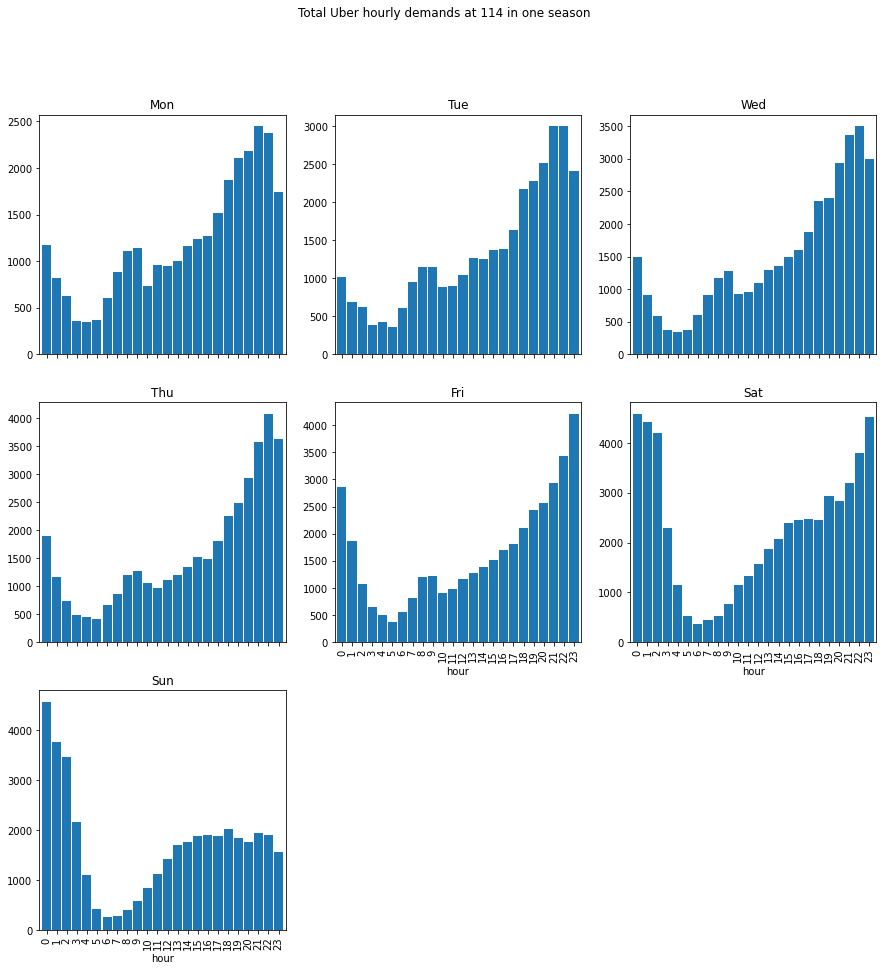

In [ ]:
def To_hour_against_weekNum(dataset, colNum):
    tmp_series = dataset.iloc[:, colNum]
    tmp_df = pd.DataFrame({'PU': tmp_series}).reset_index().rename(columns = {'index': 'PUTime'})
    tmp_df['weekNum'] = tmp_df.PUTime.dt.day_name().apply(lambda x: x[0:3])
    tmp_df['hour'] = tmp_df.PUTime.dt.hour
    '''
    groupby.agg: output three columns, [weekNum, hour, agg_sum_PU]
    unstack: [hour, agg_sum_PU on [Mon, Tue, Wed....]]
    '''
    each_week_hourly = tmp_df.groupby(['weekNum', 'hour']).agg(sum)\
                            .unstack(0)
    # from [('PU', 'Fri') ('PU', 'Mon') ('PU', 'Sat') ...] to [Fri Mon Sat ...]
    each_week_hourly.columns = each_week_hourly.columns.droplevel()
    each_week_hourly = each_week_hourly[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']]
    return each_week_hourly

colNum = 113
each_week_hourly = To_hour_against_weekNum(taxi_uber_demand, colNum)

each_week_hourly.plot.bar(subplots=True, layout=(3, 3), figsize = (15, 15), color = 'tab:blue',
                          legend = False, width=0.9, title = 'Total Uber hourly demands at '+str(colNum+1)+" in one season")
plt.savefig(image_save_path_prefix+'Total Uber hourly demands at '+str(colNum+1)+" in one season.svg", bbox_inches='tight')

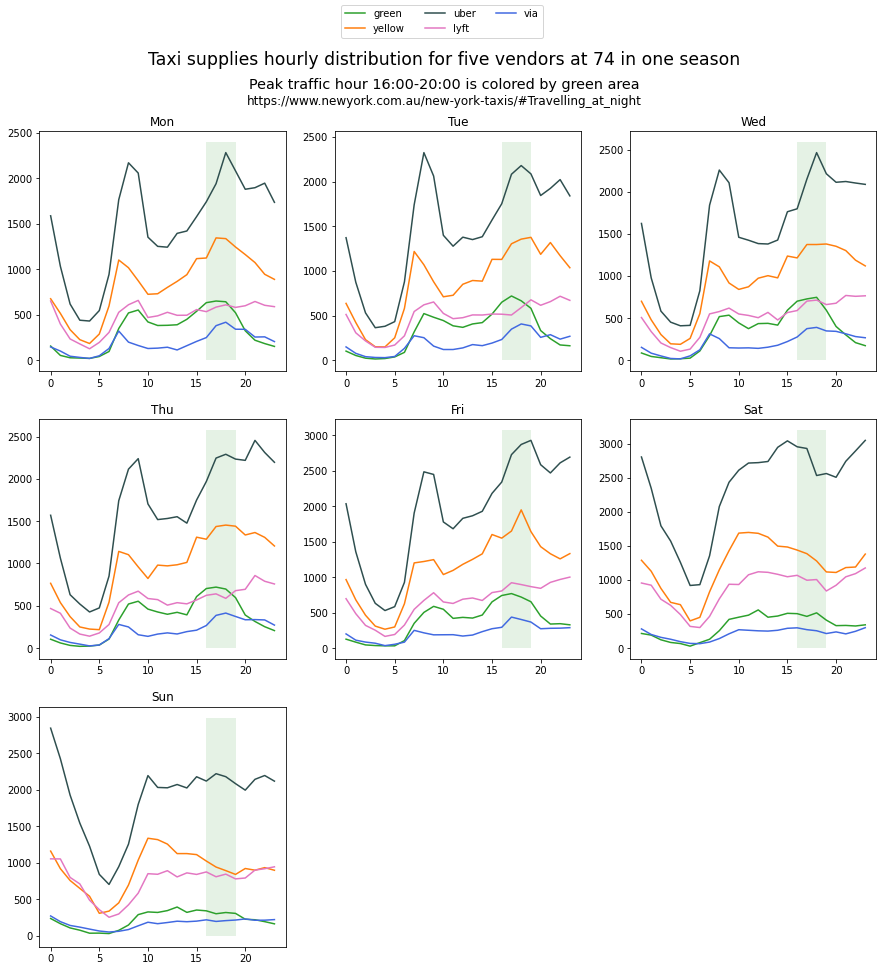

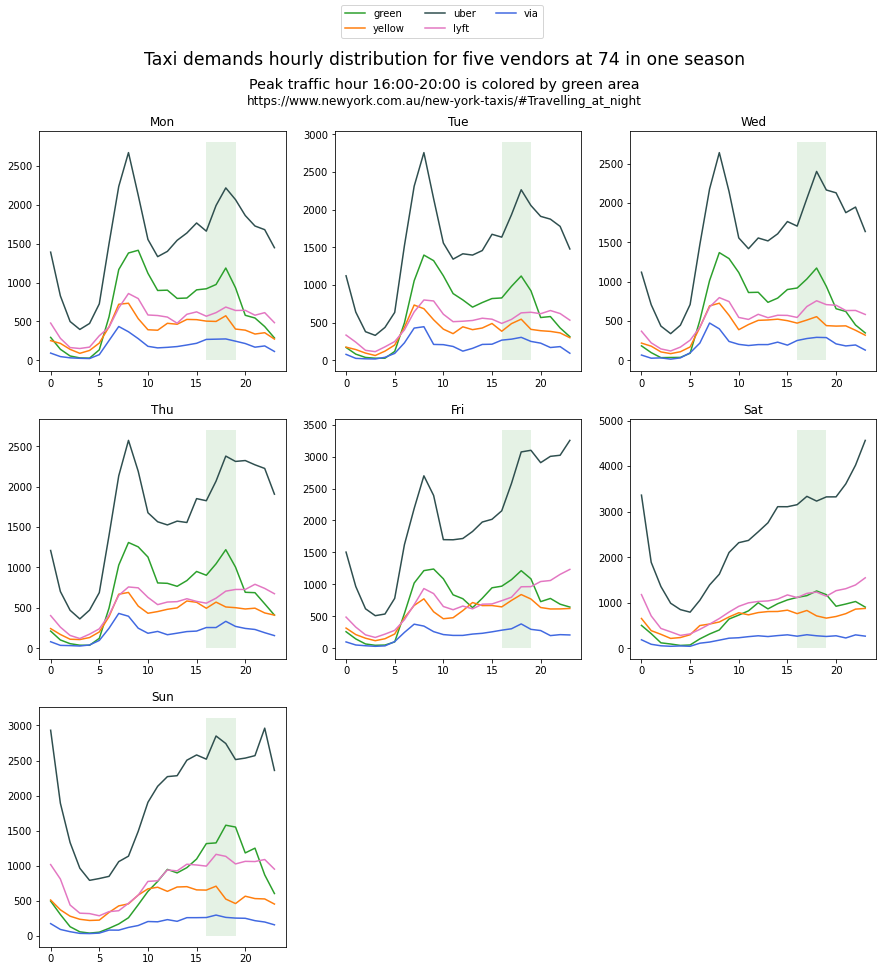

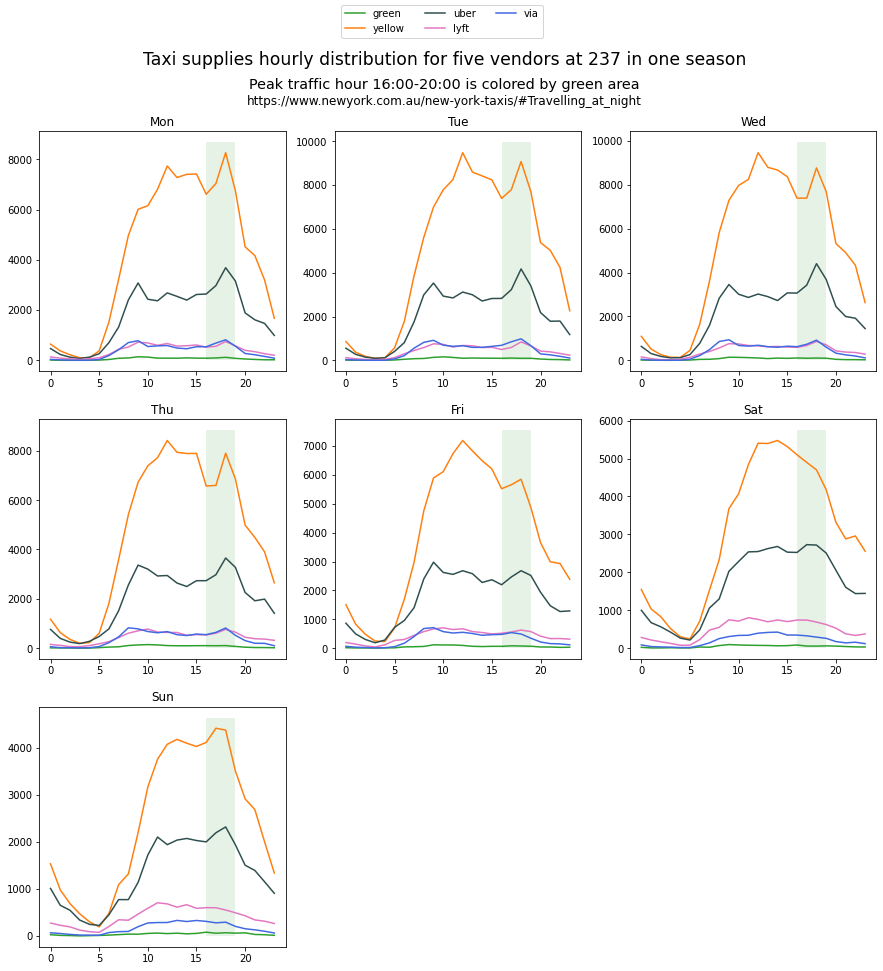

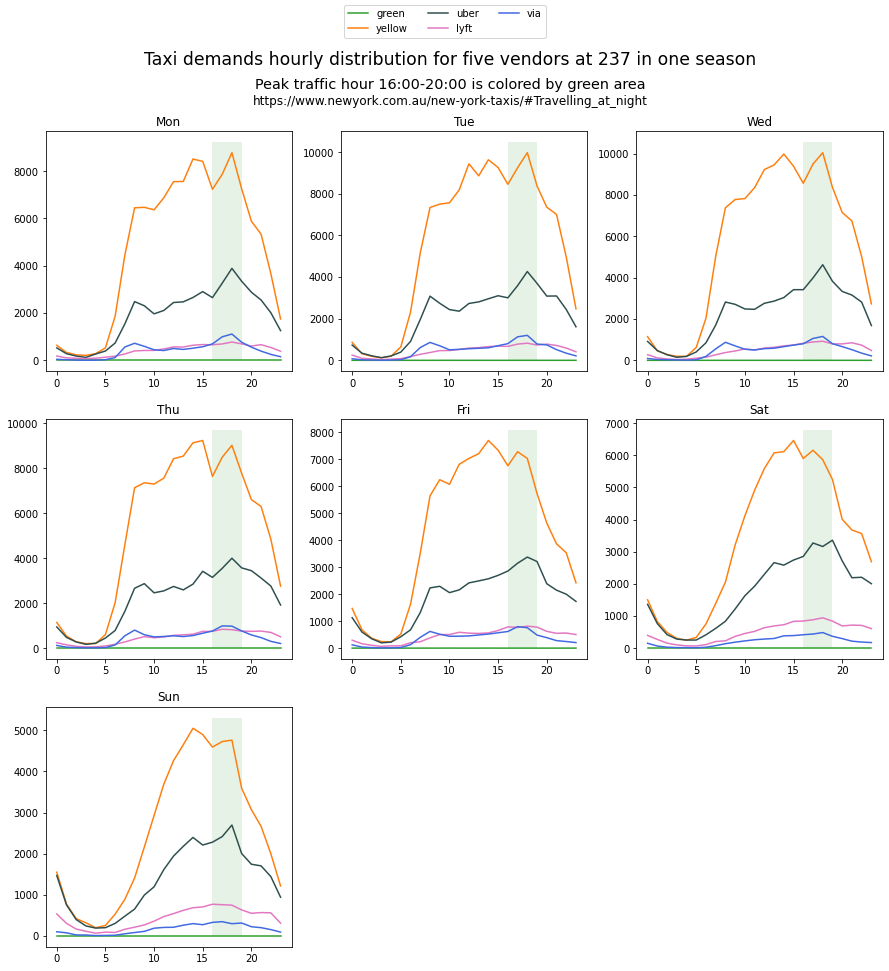

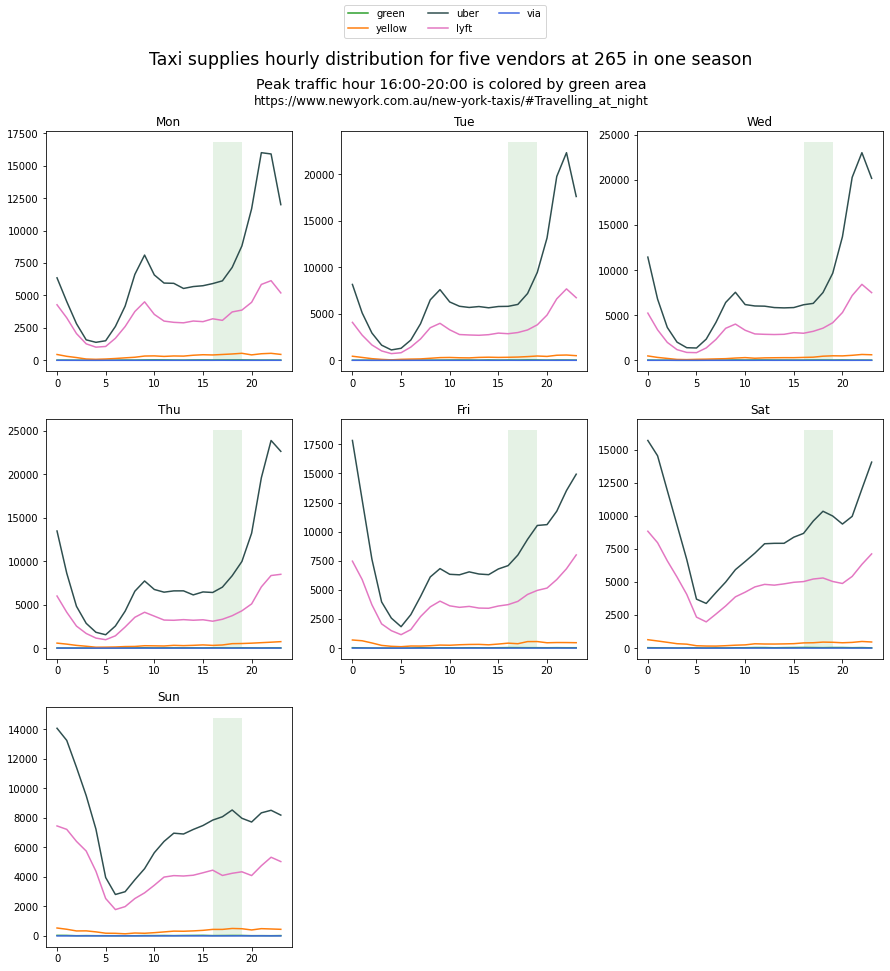

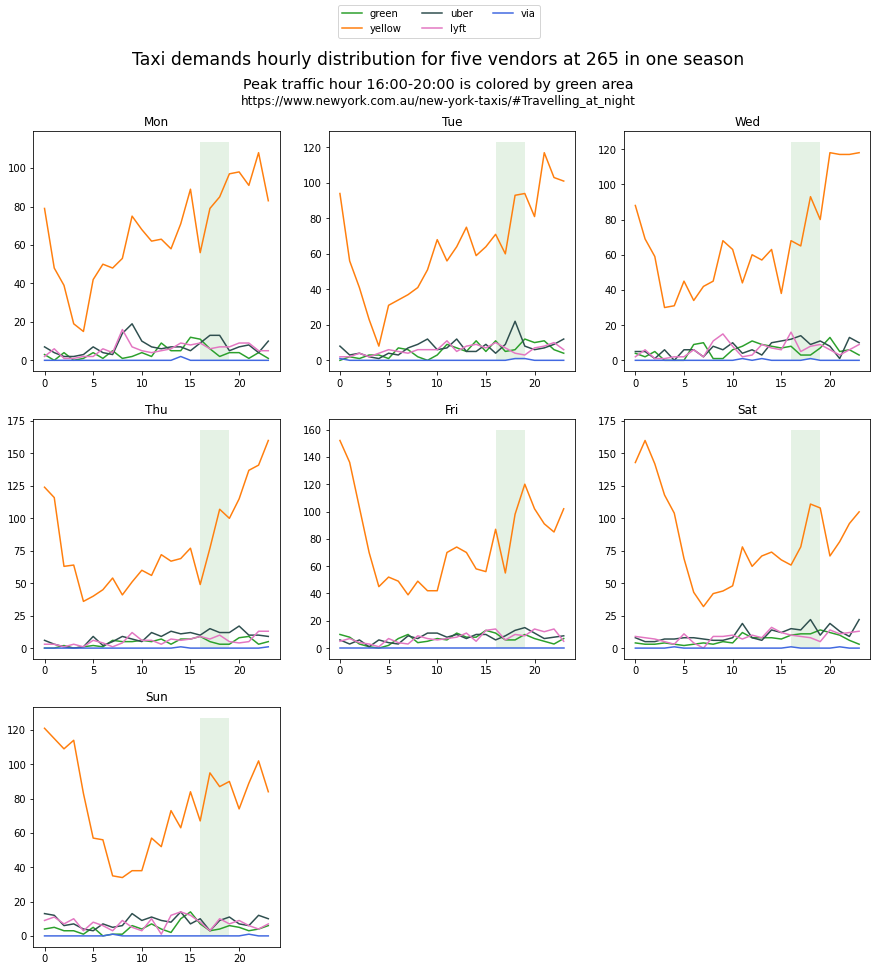

In [ ]:
taxi_colors = {'green': 'tab:green', 'yellow': 'tab:orange', 'uber': 'darkslategrey', 'via': 'royalblue', 'lyft': 'tab:pink'}

def inspect_hourly_distribution_at_location(dataset, colNum, pu_do):
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle("Taxi "+pu_do+" hourly distribution for five vendors at "+str(colNum+1)+" in one season", y=0.955, fontsize = 'xx-large')
    fig.text(0.5, 0.92, 'Peak traffic hour 16:00-20:00 is colored by green area', ha = 'center', fontsize = 'x-large')
    fig.text(0.5, 0.905, 'https://www.newyork.com.au/new-york-taxis/#Travelling_at_night', ha = 'center', fontsize = 'large')
    axs = axs.flatten()
    for taxi_demand, taxi_name in zip(dataset, taxi_names):
        weekly_PU_113 = To_hour_against_weekNum(taxi_demand, colNum)
        for i, weekDay in enumerate(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']):
            axs[i].plot(weekly_PU_113[weekDay], label = taxi_name, color = taxi_colors[taxi_name])
    for i, weekDay in enumerate(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']):
        axs[i].set_title(weekDay)
        axs[i].fill_between(np.arange(16, 20, 1), 0, axs[i].get_ylim()[1], facecolor='green', alpha=0.1)

    # only take the last one legend
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol = 3)
    axs[7].set_axis_off()
    axs[8].set_axis_off()
    fig.savefig(image_save_path_prefix+'Taxi '+pu_do+' hourly distribution for five vendors at '+str(colNum+1)+" in one season.svg",
                bbox_inches='tight')
    
colNums = [74-1, # online and traditional evenly
           237-1, # traditional dominant
           265-1] # online and traditional discrepancy
for colNum in colNums:
    inspect_hourly_distribution_at_location(taxi_supplies, colNum, 'supplies')
    inspect_hourly_distribution_at_location(taxi_demands, colNum, 'demands')

Plot the number of all orders against different locations in the summer period in 2019.

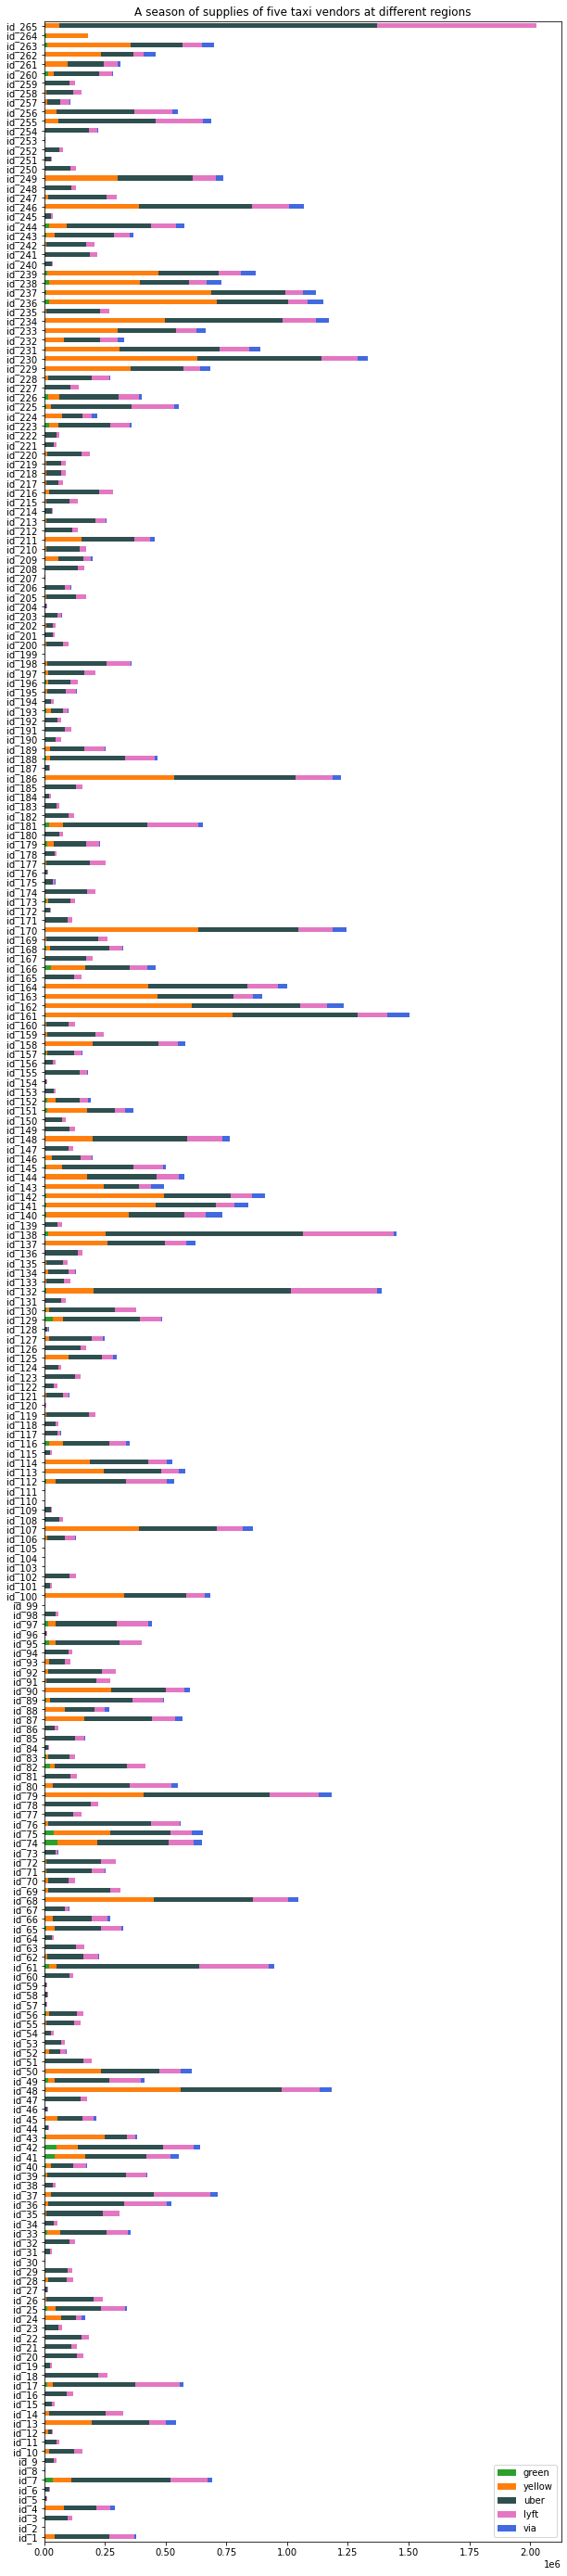

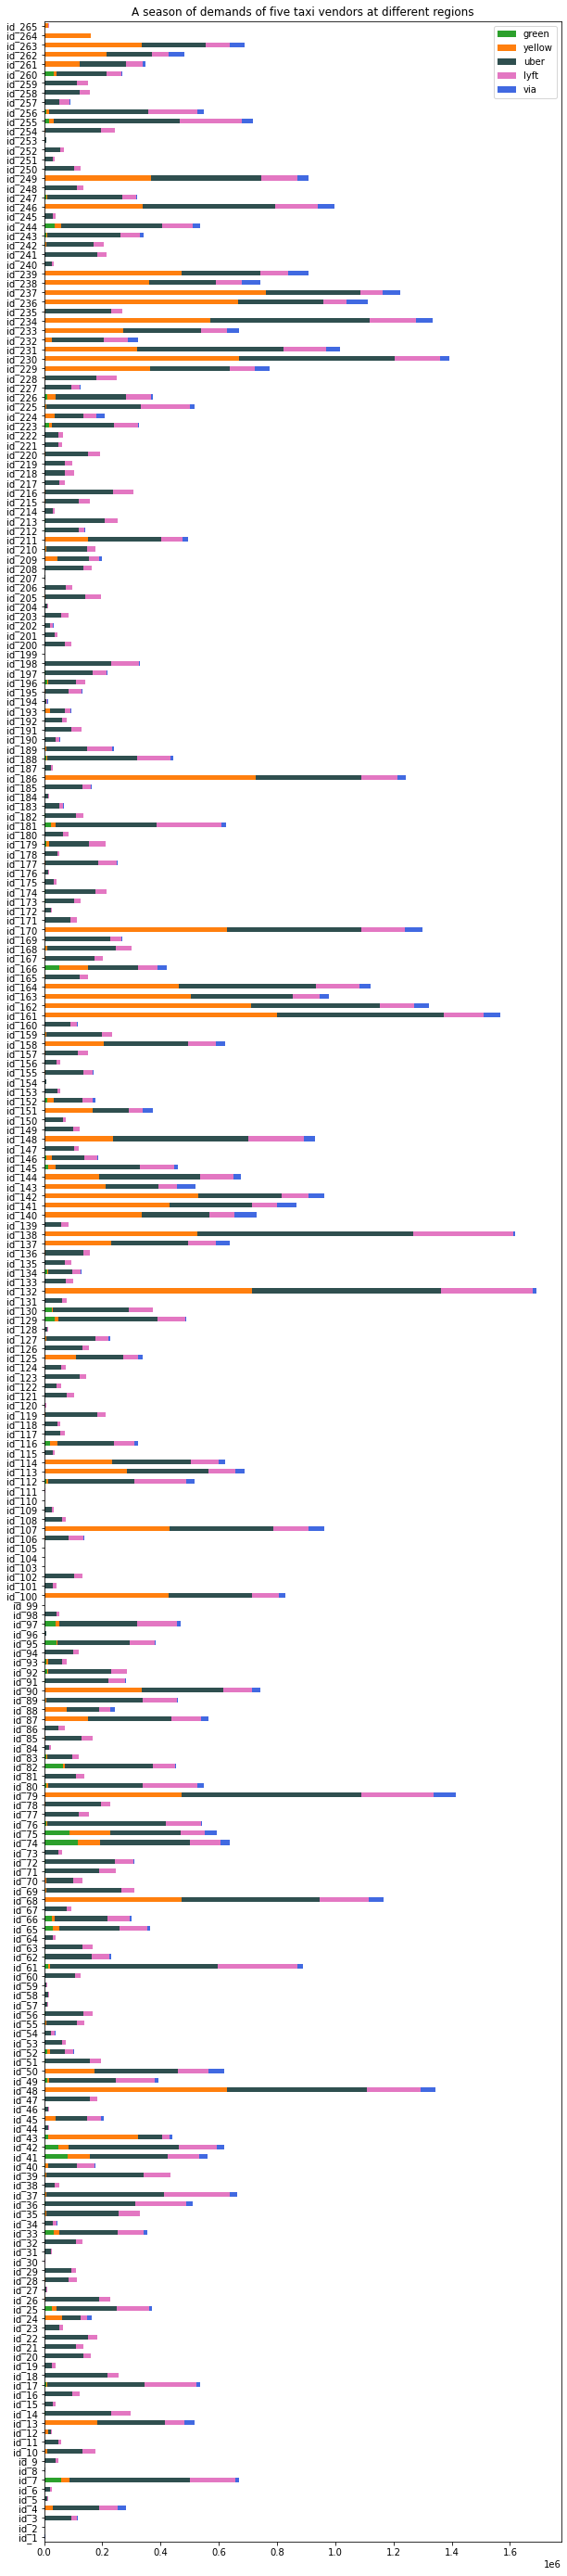

In [ ]:
def stacked_bar_on_all_regions(dataset, pu_do):
    tmp_result = []
    for taxi_supply in dataset:
        tmp_result.append(taxi_supply.agg(sum))
    tmp_result = pd.DataFrame(tmp_result, index = taxi_names)\
                    .transpose()
    tmp_result.plot.barh(stacked=True, figsize = (10, 50), color = taxi_colors,
            title='A season of '+pu_do+' of five taxi vendors at different regions')
    plt.savefig(image_save_path_prefix+"A season of "+pu_do+" of five taxi vendors at different regions.svg", 
                bbox_inches='tight')

stacked_bar_on_all_regions(taxi_supplies, 'supplies')
stacked_bar_on_all_regions(taxi_demands, 'demands')

There are some places that the traditional taxis hold less than 1% market share, may due to the user preference demographical distribution. We don't want to recommend the drivers to go to these places.

In [ ]:
# ---------- places that green+yellow occupy less than 1% market share ---------
tmp_result = []
for taxi_dem in taxi_demands:
    tmp_result.append(taxi_dem.agg(sum))
tmp_result = pd.DataFrame(tmp_result, index = taxi_names)\
                .transpose()
tmp_result['Total'] = tmp_result.sum(axis = 1)

low_market_share = tmp_result[tmp_result[['yellow', 'green']].sum(axis=1)<tmp_result['Total'] * 0.01]

print(low_market_share.index.to_list())
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(low_market_share)

['id_5', 'id_6', 'id_23', 'id_44', 'id_73', 'id_84', 'id_109', 'id_110', 'id_115', 'id_118', 'id_156', 'id_172', 'id_176', 'id_180', 'id_187', 'id_198', 'id_201', 'id_204', 'id_206', 'id_214', 'id_221', 'id_245', 'id_251']


,green,yellow,uber,lyft,via,Total
id_5,3,115,11159,2465,2,13744
id_6,16,48,21624,4187,33,25908
id_23,58,142,52512,12262,32,65006
id_44,3,107,15464,2806,1,18381
id_73,350,163,48882,11437,140,60972
id_84,0,14,18652,3551,6,22223
id_109,12,24,27861,4904,3,32804
id_110,0,0,119,20,0,139
id_115,165,38,28261,7038,35,35537
id_118,21,112,44907,9316,17,54373
